# Classification of STFTs using Neural Networks
This notebook trains a densely connected TensorFlow neural network, and a convolutional neural network, on the short term Fourier transforms of PSG-labled accelerometer data. The original accelerometer data can be generated using Dr. Olivia Walch's <a href=""><code>sleep_classifiers</code></a> project.

If you are viewing this on GitHub, I invite you to try the Notebook on Google Colab: https://colab.research.google.com/drive/1S0x3kIIwaSH3bDPteOlRET--e0cbm_sb

## * ETL:
The <code>pickled</code> data is the short term Fourier transform restulting from the following process:
1. Load the <code>(timestamp, x,y,z)</code> acceleration timeseries for each subject in Dr. Walch's study.
2. Take a temporal numerical derivative of the magnitude of <code>(x,y,z)</code> components.
3. Considering 30 second intervals of this derivative, we interpolate the data to be evaluated on <code>np.arange(0, 30, 0.02)</code>, with this step size of 0.02 seconds chosen based on sampling statistics of time differentials over all subjects.  
4. For each time segment, take a short term Fourier transform using <code>scipy.signal.sftf</code> with 65 frequencies per transform. These transforms have been <code>pickled</code> into <code>"stfts.pickle"</code>, along with a pickled NumPy array holding the PSG labels [0, ..., 5] (along with several -1).

The array <code>ys</code> of labels is transformed into a binary array using <code>np.where(ys > 0, 1, 0)</code> before we fit the neural network. 

In case you don't have them already, you can access the data at these links:


*   <code>labels.pickle</code>: https://drive.google.com/open?id=1u_g2sowu0ZD9inNbRB41oKPwsmFiksTY
*   <code>stfts.pickle</code>: https://drive.google.com/open?id=1DDbrczvlrLOAxrb1Sos3mHFVf6-X0v6C



## * Models

We build three classification models: a dense neural network, a convolutional neural network, and a log regression model, and evaluate their classifcation capabilities on scaled and unscaled STFTs. The scaling transforms the values in the STFTs to fill the interval [0,  255], which is the usual value for greyscale images. 

### Neural Networks
For the dense neural network, we do some trivial modifications to the neural network from the basis <a href="https://www.tensorflow.org/tutorials/keras/classification">TensorFlow image classification tutorial notebook</a>. 

For the convolutional neural network, we also follow quite closely the <a href="https://www.tensorflow.org/tutorials/images/cnn?hl=en">TensorFlow CNN tutorial</a>, albeit with one fewer max poolin and convolutional layer.  

### Stochastic Gradient Descent Log Regression
For a comparison of performance with more classical ML, in the third section we evaluate a log regression model on the scaled and unscaled data. 

## * Takeaways
Precision and recall, per class, from a recent run are found below. 

DNN trained on unscaled data:

              precision    recall

       Awake       0.97      0.12
      Asleep       0.89      1.00
           
DNN trained on scaled data:

              precision    recall

       Awake       0.75      0.02
      Asleep       0.90      1.00 
           
CNN trained on unscaled data:

              precision    recall

       Awake       0.71      0.29
      Asleep       0.91      0.98 
           
CNN trained on scaled data (this often has precision/recall 0 for Awake):

              precision    recall 

       Awake       0.60      0.02  
      Asleep       0.89      1.00  
           
Log regression trained on unscaled data:

              precision    recall

       Awake       0.21      0.52
      Asleep       0.92      0.74

Log regression trained on scaled data:

              precision    recall

       Awake       0.32      0.15
      Asleep       0.91      0.96



In [0]:
import pickle

# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [0]:
# Do this to mount your Drive
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# You can get thise filename, once your Drive is connected to Colab, 
# by finding the file on the left sidebar, right clicking, then "Copy path"
stft_file = "/content/drive/My Drive/Colab Notebooks/stfts.pickle"
labels_file = "/content/drive/My Drive/Colab Notebooks/labels.pickle"

In [0]:
with open(stft_file, "rb") as f:
  stfts = pickle.load(f)

In [0]:
with open(labels_file, "rb") as f:
  ys = pickle.load(f)

In [5]:
# numpy.ndarray
type(stfts)

numpy.ndarray

In [6]:
# (23857, 65, 25)
stfts.shape

(23857, 65, 25)

In [7]:
# (23857,)
ys.shape

(23857,)

In [0]:
# Used to scale the STFTs so their values lie in [0, 255] instead of [-100, 36].
# This is the usual range for black-and-white images. 
# Surprisingly (to me), this has a large impact on the classification power of the neural networks we build. 
def greyscaler(X):
  if X.min() == X.max():
    print("Error: cannot scale a constant array.")
    return None
  else:
    return 255.0*(X - X.min())/(X.max() - X.min())

In [0]:
stfts_scaled = greyscaler(stfts)

In [0]:
# Convert Wake, NREM_m, REM classes into wake 0 /sleep 1
ys_sw = np.where(ys > 0, 1, 0)

We will get two pairs of train/test splits, one for the scaled data and one for unscaled data. These are used throughout the Notebook for comparing the models and also exploring the impact of scaling on the classification capabilities. 

In [0]:
# Get a train 90/test 10 split
S_train, S_test, y_train, y_test = train_test_split(stfts, ys_sw, test_size=0.1)

# Get a train 90/test 10 split of the scaled data, for performance comparison
S_train_scaled, S_test_scaled, y_train_scaled, y_test_scaled = train_test_split(stfts_scaled, ys_sw, test_size=0.1)

## Visualization of the SFTFs
Before training the neural network, let's take a peek at the STFTs we loaded. There are a lot, so the cell below helps by choosing 9 of the STFTs at random and then plotting them. Each time you run this cell it picks a diffferent subset.

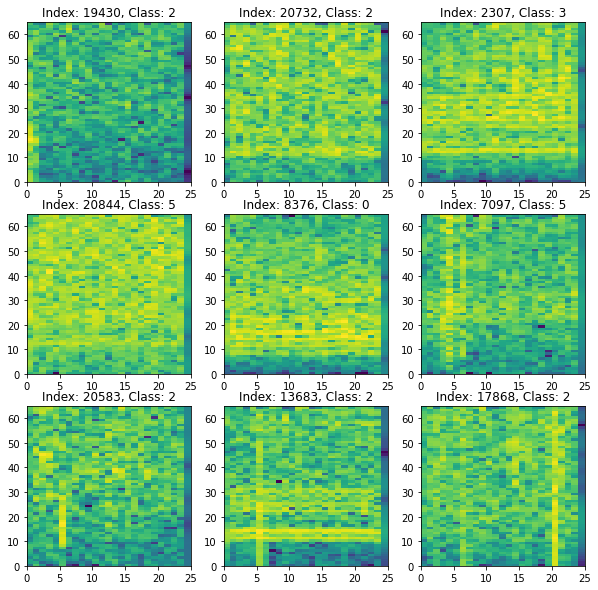

In [29]:
import random

ys_len = len(ys)

# Randomly select 9 indices for plotting the colormesh of their stft.
# Running this cell repeatedly gives a new subset each time.
inds = random.sample(range(ys_len), k=9)

# mapping dict taking pairs (i,j) to our random indices
# Used in for loop to plot random subset of our data.
mapper = {
    (0,0) : inds[0],
    (0,1) : inds[1],
    (0,2) : inds[2],
    (1,0) : inds[3],
    (1,1) : inds[4],
    (1,2) : inds[5],
    (2,0) : inds[6],
    (2,1) : inds[7],
    (2,2) : inds[8],
}

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(10,10))

for i in [0,1,2]:
    for j in [0,1,2]:
        index = mapper[(i,j)]
        X = stfts_scaled[index]
        y = ys[index]
        axs[i][j].pcolormesh(X)
        axs[i][j].set_title("Index: {}, Class: {}".format(index, y))

# 1. Dense Neural Network
Our network design choices are trivial modifications of the network set up in the classification TensorFlow tutorial. We make two models with identical layer blueprints so their fittings are independent (subsequent calls to the <code>fit</code> method continue with previously fitted parameters, eventually leading to a precision and recall of 0 for the awake class.)

In [0]:
dnn_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(65, 25)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])


dnn_model_scaled = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(65, 25)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [0]:
dnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

dnn_model_scaled.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) 
              

In [14]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1625)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               208128    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 208,386
Trainable params: 208,386
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Ensure the GPU is available. 
# This speeds up training the NNs, with significant gains on the CNN.
device_name = tf.test.gpu_device_name()
if device_name.find("GPU") < 0:
  print("No GPU found!")
else:
  print(device_name)

/device:GPU:0


In [16]:
# If you don't have GPUs available, you can run dnn_model.fit on its own. 
# The main difference is how rapidly training proceeds. 
with tf.device(device_name):
  dnn_model.fit(S_train, y_train, epochs=10)

print("=================================================================")
y_pred = np.argmax(dnn_model.predict(S_test), axis=-1)
print("DNN trained on unscaled data:")
print(classification_report(y_test, y_pred, target_names=["Awake", "Asleep"]))

Epoch 1/10
671/671 [==============================] - 2s 3ms/step - loss: 9.2233 - accuracy: 0.8398
Epoch 2/10
671/671 [==============================] - 2s 3ms/step - loss: 3.1941 - accuracy: 0.8478
Epoch 3/10
671/671 [==============================] - 2s 3ms/step - loss: 1.6056 - accuracy: 0.8540
Epoch 4/10
671/671 [==============================] - 2s 3ms/step - loss: 0.7229 - accuracy: 0.8682
Epoch 5/10
671/671 [==============================] - 2s 3ms/step - loss: 0.4702 - accuracy: 0.8824
Epoch 6/10
671/671 [==============================] - 2s 3ms/step - loss: 0.3201 - accuracy: 0.9070
Epoch 7/10
671/671 [==============================] - 2s 3ms/step - loss: 0.2838 - accuracy: 0.9130
Epoch 8/10
671/671 [==============================] - 2s 3ms/step - loss: 0.2771 - accuracy: 0.9134
Epoch 9/10
671/671 [==============================] - 2s 3ms/step - loss: 0.2807 - accuracy: 0.9127
Epoch 10/10
671/671 [==============================] - 2s 3ms/step - loss: 0.2860 - accuracy: 0.9114

In [17]:
with tf.device(device_name):
  dnn_model_scaled.fit(S_train_scaled, y_train_scaled, epochs=10)

print("=================================================================")
y_pred_scaled = np.argmax(dnn_model_scaled.predict(S_test_scaled), axis=-1)
print("DNN trained on scaled data:")
print(classification_report(y_test_scaled, y_pred_scaled, target_names=["Awake", "Asleep"]))

Epoch 1/10
671/671 [==============================] - 2s 3ms/step - loss: 20.0652 - accuracy: 0.8210
Epoch 2/10
671/671 [==============================] - 2s 3ms/step - loss: 9.6550 - accuracy: 0.8313
Epoch 3/10
671/671 [==============================] - 2s 3ms/step - loss: 8.1544 - accuracy: 0.8315
Epoch 4/10
671/671 [==============================] - 2s 3ms/step - loss: 5.1026 - accuracy: 0.8390
Epoch 5/10
671/671 [==============================] - 2s 3ms/step - loss: 5.0819 - accuracy: 0.8352
Epoch 6/10
671/671 [==============================] - 2s 3ms/step - loss: 3.8928 - accuracy: 0.8351
Epoch 7/10
671/671 [==============================] - 2s 3ms/step - loss: 2.9750 - accuracy: 0.8370
Epoch 8/10
671/671 [==============================] - 2s 3ms/step - loss: 1.7354 - accuracy: 0.8484
Epoch 9/10
671/671 [==============================] - 2s 3ms/step - loss: 1.6360 - accuracy: 0.8449
Epoch 10/10
671/671 [==============================] - 2s 3ms/step - loss: 1.0284 - accuracy: 0.848

# 2. Convolutional Neural Network
Next we add convolutional layers, with max pooling between the convolutions, before passing the STFTs through two dense layers. As a first step, we need to reshape our data so that it can be passed through the <code>Conv2D</code> TensorFlow layers, which require higher-order tensors of type <code>(length, width, color/intensity)</code>. We do this by reshaping the train and test splits, essentially giving them the structure of black and white images (i.e. the colormeshes we created before) with shape <code>(65, 25, 1)</code>. The actual shape of <code>S_train_bw</code> is <code>(21471, 65, 25, 1)</code>, indicating we have 21471 samples in this training set.


In [0]:
# Apply reshaping to the unscaled and scaled train/test sets. 

S_train_bw = S_train.reshape(S_train.shape[0], 65, 25, 1) 
S_test_bw = S_test.reshape(S_test.shape[0], 65, 25, 1)

S_train_scaled_bw = S_train_scaled.reshape(S_train_scaled.shape[0], 65, 25, 1)
S_test_scaled_bw = S_test_scaled.reshape(S_test_scaled.shape[0], 65, 25, 1)

In [19]:
# Check that these are now (n_samples, 65, 25, 1) tensors
print("Unscaled:")
print(S_train_bw.shape)
print(S_test_bw.shape)

print("\nScaled:")
print(S_train_scaled_bw.shape)
print(S_test_scaled_bw.shape)

Unscaled:
(21471, 65, 25, 1)
(2386, 65, 25, 1)

Scaled:
(21471, 65, 25, 1)
(2386, 65, 25, 1)


In [0]:
cnn_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=32, 
                      kernel_size=3, 
                      activation='relu', 
                      input_shape=(65, 25, 1)),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Conv2D(filters=64, 
                      kernel_size=3, 
                      activation='relu'), 
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(2)                                    
])


cnn_model_scaled = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=32, 
                      kernel_size=3, 
                      activation='relu', 
                      input_shape=(65, 25, 1)),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Conv2D(filters=64, 
                      kernel_size=3, 
                      activation='relu'), 
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(2)                                    
])

In [21]:
cnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

cnn_model_scaled.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Ensure the neural networks are set up as we expect.
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 63, 23, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 11, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 9, 64)         18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 16704)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                1069120   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 1,088,066
Trainable params: 1,088,066
Non-trainable params: 0
____________________________________________

In [22]:
# If you don't have GPUs available, you can call cnn_model.fit on its own. 
# The main advantage is that GPUs significantly speed up the training epochs.
with tf.device(device_name):
  cnn_model.fit(x=S_train_bw, y=y_train, epochs=10, verbose=2)

print("=================================================================")
print("CNN trained on unscaled data:")
y_cnn_pred = np.argmax(cnn_model.predict(S_test_bw), axis=-1)
print(classification_report(y_test, y_cnn_pred, target_names=["Awake", "Asleep"]))

Epoch 1/10
671/671 - 4s - loss: 0.6696 - accuracy: 0.9036
Epoch 2/10
671/671 - 3s - loss: 0.2788 - accuracy: 0.9133
Epoch 3/10
671/671 - 3s - loss: 0.2875 - accuracy: 0.9136
Epoch 4/10
671/671 - 3s - loss: 0.2754 - accuracy: 0.9164
Epoch 5/10
671/671 - 3s - loss: 0.2729 - accuracy: 0.9152
Epoch 6/10
671/671 - 3s - loss: 0.2752 - accuracy: 0.9156
Epoch 7/10
671/671 - 3s - loss: 0.2685 - accuracy: 0.9161
Epoch 8/10
671/671 - 3s - loss: 0.2677 - accuracy: 0.9174
Epoch 9/10
671/671 - 3s - loss: 0.2665 - accuracy: 0.9175
Epoch 10/10
671/671 - 3s - loss: 0.2687 - accuracy: 0.9173
CNN trained on unscaled data:
              precision    recall  f1-score   support

       Awake       0.71      0.29      0.42       285
      Asleep       0.91      0.98      0.95      2101

    accuracy                           0.90      2386
   macro avg       0.81      0.64      0.68      2386
weighted avg       0.89      0.90      0.88      2386



In [23]:
with tf.device(device_name):
  cnn_model_scaled.fit(x=S_train_scaled_bw, y=y_train_scaled, epochs=10, verbose=2)
  
print("=================================================================")
print("CNN trained on scaled data:")
y_cnn_pred_scaled = np.argmax(cnn_model_scaled.predict(S_test_scaled_bw), axis=-1)
print(classification_report(y_test_scaled, y_cnn_pred_scaled, target_names=["Awake", "Asleep"]))

Epoch 1/10
671/671 - 4s - loss: 1.3644 - accuracy: 0.8907
Epoch 2/10
671/671 - 3s - loss: 0.3344 - accuracy: 0.8996
Epoch 3/10
671/671 - 3s - loss: 0.3208 - accuracy: 0.9021
Epoch 4/10
671/671 - 3s - loss: 0.3158 - accuracy: 0.9014
Epoch 5/10
671/671 - 3s - loss: 0.3470 - accuracy: 0.8966
Epoch 6/10
671/671 - 3s - loss: 0.3269 - accuracy: 0.8976
Epoch 7/10
671/671 - 3s - loss: 0.3310 - accuracy: 0.8976
Epoch 8/10
671/671 - 3s - loss: 0.3381 - accuracy: 0.8976
Epoch 9/10
671/671 - 3s - loss: 0.3381 - accuracy: 0.8977
Epoch 10/10
671/671 - 3s - loss: 0.3330 - accuracy: 0.8976
CNN trained on scaled data:
              precision    recall  f1-score   support

       Awake       0.00      0.00      0.00       244
      Asleep       0.90      1.00      0.95      2142

    accuracy                           0.90      2386
   macro avg       0.45      0.50      0.47      2386
weighted avg       0.81      0.90      0.85      2386



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 3. Logistic Regression Classifier (Stochastic Gradient Descent)
For a comparison with classical classification, let's take a look at how <code>sklearn.linear_model.SGDClassifier</code> with a log-loss and class-balanced weights compares with our two neural networks.

In [0]:
from sklearn.linear_model import SGDClassifier

In [0]:
log_reg = SGDClassifier(loss='log', class_weight='balanced')

In [0]:
# Flatten our STFTs so they can be processed by log_reg
# Similar to our Flatten layer preceeding the dense layers above
S_train_flat = np.array([s.flatten() for s in S_train])
S_test_flat = np.array([s.flatten() for s in S_test])

S_train_scaled_flat = np.array([s.flatten() for s in S_train_scaled])
S_test_scaled_flat = np.array([s.flatten() for s in S_test_scaled])

In [34]:
log_reg.fit(S_train_flat, y_train)

y_log_pred = log_reg.predict(S_test_flat)

print("Log regression trained on unscaled data:")
print(classification_report(y_test, y_log_pred, target_names=["Awake", "Asleep"]))

Log regression trained on unscaled data:
              precision    recall  f1-score   support

       Awake       0.21      0.52      0.30       285
      Asleep       0.92      0.74      0.82      2101

    accuracy                           0.71      2386
   macro avg       0.56      0.63      0.56      2386
weighted avg       0.83      0.71      0.76      2386



In [35]:
log_reg.fit(S_train_scaled_flat, y_train_scaled)

y_log_scaled_pred = log_reg.predict(S_test_scaled_flat)

print("Log regression trained on scaled data:")
print(classification_report(y_test_scaled, y_log_scaled_pred, target_names=["Awake", "Asleep"] ))

Log regression trained on scaled data:
              precision    recall  f1-score   support

       Awake       0.32      0.15      0.21       244
      Asleep       0.91      0.96      0.94      2142

    accuracy                           0.88      2386
   macro avg       0.62      0.56      0.57      2386
weighted avg       0.85      0.88      0.86      2386

